In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.6 MB/s eta 0:00:00


In [2]:
# Get the dataset
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2023-02-24 08:02:03--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  2.67MB/s    in 1.2s    

2023-02-24 08:02:05 (2.67 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [3]:
ls

AirlineTweets.csv  sample_data/


In [4]:
# Import what we need
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix 
from sklearn.model_selection import train_test_split


In [5]:
# Basic usage, get the appropriate model for the task
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [6]:
# Check the typ of the classifier variable to see what it is
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [7]:
# Use the classifier object to make predictions
# Output is a dictonary
classifier("This is such a great movie!")

[{'label': 'POSITIVE', 'score': 0.9998759031295776}]

In [8]:
classifier("This show was not interesting")

[{'label': 'NEGATIVE', 'score': 0.9997871518135071}]

In [9]:
classifier("This show was interresting")

[{'label': 'NEGATIVE', 'score': 0.9923043847084045}]

In [10]:
classifier("This show was not bad at all")

[{'label': 'POSITIVE', 'score': 0.998742401599884}]

In [11]:
classifier("I can't say that this was a good move")

[{'label': 'NEGATIVE', 'score': 0.992453396320343}]

In [12]:
classifier("Maten var god")

[{'label': 'POSITIVE', 'score': 0.7729606628417969}]

In [13]:
# Multiple inputs passed in as a list
classifier(["This course is just what I need.",
            "I can't understand any of this. Instructor kept telling me to meet the \
            prerequisites. What are prerequisittes? Why does he keepp saying that?"])

[{'label': 'POSITIVE', 'score': 0.9993603825569153},
 {'label': 'NEGATIVE', 'score': 0.9977218508720398}]

##Pipelines does not exist on GPU's, this iw what we need if we are going to use them on a whole dataset

In [14]:
# Environment
import torch

In [15]:
# Check if cuda(GPU) is avalible
torch.cuda.is_available()

True

In [16]:
#To check if GPU is running or not, run the following command

!nvidia-smi


Fri Feb 24 08:02:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
# Use the return to refer to the gpu
torch.cuda.current_device()

0

In [18]:
# Create a new pipeline object to pass in sentiment analysis
# Use the GPU(device=0)
classifier = pipeline("sentiment-analysis", device=0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [19]:
# Read in the csv-file
df_ = pd.read_csv('/content/AirlineTweets.csv')

In [20]:
# Call the head function to see whats inside our dataframe
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [21]:
# Filter our dataframe
# We are interested in the tweets and the coresponding labels
df = df_[['airline_sentiment', 'text']].copy()

<AxesSubplot:>

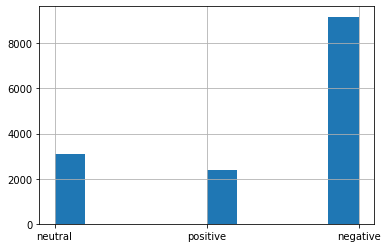

In [22]:
# Plot a histogram of our labels, to se if the data is imbalaned and show what classes there is in the dataset
df['airline_sentiment'].hist()

In [23]:
# Remove the neutral because the model can not predict this class anyway
df = df[df.airline_sentiment != 'neutral'].copy()

In [24]:
# Map our labels to integers, for usefulness later on, assigning the new column to 'target'
target_map = {'positive':1, 'negative':0}
df['target'] = df['airline_sentiment'].map(target_map)

In [25]:
# Inspect the dataframe again, we got our new target column(1=positive, 0=negative)
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [26]:
# Check how many smaples we have
len(df)

11541

In [28]:
# Use our pre-trained classifier to get predictions
texts = df['text'].tolist()
predictions = classifier(texts)

In [30]:
# Print out the predictions
predictions

[{'label': 'POSITIVE', 'score': 0.6070823669433594},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854250550270081},
 {'label': 'POSITIVE', 'score': 0.9553212523460388},
 {'label': 'POSITIVE', 'score': 0.9827088117599487},
 {'label': 'POSITIVE', 'score': 0.9994851350784302},
 {'label': 'POSITIVE', 'score': 0.9993509650230408},
 {'label': 'POSITIVE', 'score': 0.9940821528434753},
 {'label': 'POSITIVE', 'score': 0.9863133430480957},
 {'label': 'POSITIVE', 'score': 0.9996304512023926},
 {'label': 'NEGATIVE', 'score': 0.9980512857437134},
 {'label': 'POSITIVE', 'score': 0.9964436888694763},
 {'label': 'NEGATIVE', 'score': 0.9968666434288025},
 {'label': 'POSITIVE', 'score': 0.9787647724151611},
 {'label': 'POSITIVE', 'score': 0.9995218515396118},
 {'label': 'NEGATIVE', 'score': 0.9954516291618347},
 {'label': 'POSITIVE', 'score': 0.9995624423027039},
 {'label': 'POSITIVE', 'score': 0.999874830245

In [32]:
# The data is impalanced, prob are both positive and negative. Set all prob to positive  so that they can be analyzed. 
probs = [d['score'] if d['label'].startswith('P') else 1-d['score'] \
         for d in predictions]

In [33]:
# Print to see what we got back, som enumbers got very small
probs

[0.6070823669433594,
 0.0026550889015197754,
 0.0004176497459411621,
 0.014574944972991943,
 0.9553212523460388,
 0.9827088117599487,
 0.9994851350784302,
 0.9993509650230408,
 0.9940821528434753,
 0.9863133430480957,
 0.9996304512023926,
 0.001948714256286621,
 0.9964436888694763,
 0.0031333565711975098,
 0.9787647724151611,
 0.9995218515396118,
 0.004548370838165283,
 0.9995624423027039,
 0.9998748302459717,
 0.004880666732788086,
 0.00040477514266967773,
 0.0006322264671325684,
 0.015428304672241211,
 0.01828092336654663,
 0.0004482865333557129,
 0.0023748278617858887,
 0.9934480786323547,
 0.9976067543029785,
 0.8661723136901855,
 0.0003237724304199219,
 0.8415611386299133,
 0.0032317638397216797,
 0.9997846484184265,
 0.17614370584487915,
 0.9993895292282104,
 0.09156644344329834,
 0.004861712455749512,
 0.9997820258140564,
 0.0014235973358154297,
 0.004673957824707031,
 0.00464242696762085,
 0.019041001796722412,
 0.991169810295105,
 0.0125504732131958,
 0.00809931755065918,
 0.9

In [34]:
# Convert the predictions into an array, P=1 else(negative) = 0
preds = [1 if d['label'].startswith('P') else 0 for d in predictions]

In [35]:
# Cast the list into a np array
preds = np.array(preds)

In [36]:
# Compute the acc, wich is the mean of the targets, almost 90%. Quite good as the model have never senna tweets before
print('acc:', np.mean(df['target'] == preds))

acc: 0.8898708950697514


In [37]:
# Compute the cf, norm true so each row sums to 1
cm = confusion_matrix(df['target'], preds, normalize='true')
cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

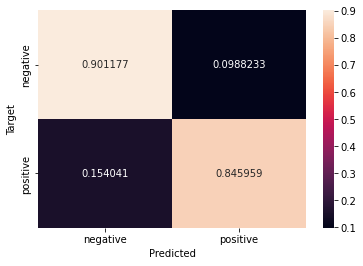

In [38]:
# Scikit-Learn is transitoning to V1 but it's not avalible on colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

In [39]:
# Check the f1 score
f1_score(df['target'], preds)

0.7587777566900741

In [40]:
# Invert the pred
f1_score(1 - df['target'], 1 - preds)

0.928647616908999

In [41]:
# Check the auc
roc_auc_score(df['target'], probs)

0.9485933999009757

In [42]:
# Invert, auc is not dependent on label assignment
roc_auc_score(1 - df['target'], 1 - np.array(probs))

0.9485933999009756